# CAPM
The expected return of asset $i$, $\mathbb{E}(R_i)$, is given by \begin{equation} \mathbb{E}(R_i) = R_f + \beta_{im} (\mathbb{E}(R_m)-R_f), \end{equation} with \begin{equation} \beta_{im}=\frac{Cov(R_i,R_m)}{Var(R_m)}, \end{equation} where
- $R_m$ is the return on the market portfolio
- $R_f$ is the return on the risk free asset

The Beta, $\beta$, of an asset is a measure of the sensitivity of its returns relative to a market benchmark.

In [11]:
# libraries
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import getFamaFrenchFactors as gff

In [44]:
# get the data
ticker = "AMZN"
stock_data = yf.download(ticker, start="2017-09-05", end="2022-09-05")
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-09-05,48.770000,48.838501,48.018501,48.263500,48.263500,57664000
2017-09-06,48.416000,48.591999,48.029999,48.389999,48.389999,42598000
2017-09-07,48.700001,49.029499,48.627499,48.973499,48.973499,51336000
2017-09-08,48.955002,48.993999,48.173500,48.294998,48.294998,52106000
2017-09-11,48.723000,49.097000,48.710999,48.897999,48.897999,43734000


In [45]:
# transform daily data into monthly data
stock_prices = stock_data['Adj Close']
stock_prices = stock_prices.resample("1M").last()
returns = stock_prices.pct_change()
returns = returns.dropna()
returns.name = 'Asset'
returns.head() # --> monthly returns

Date
2017-10-31    0.149717
2017-11-30    0.064662
2017-12-31   -0.006187
2018-01-31    0.240639
2018-02-28    0.042429
Freq: M, Name: Asset, dtype: float64

In [46]:
stock_prices.head()

Date
2017-09-30    48.067501
2017-10-31    55.264000
2017-11-30    58.837502
2017-12-31    58.473499
2018-01-31    72.544502
Freq: M, Name: Adj Close, dtype: float64

## Method 1: get $R_f$ and $R_m$ from the Kenneth R. French's website

Now, we need the risk-free rate and market return. The market return is the return on a theoretical portfolio of all assets in the current market where the portfolio is weighted for value. A typical good representation of the market portfolio is the S&P500. However, in this exercise I follow this [article](https://medium.com/the-handbook-of-coding-in-finance/how-to-calculate-expected-returns-of-stocks-using-capm-in-python-d9fac4d9cbbc), in which the author recomends the use of [Kenneth R. French's website](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html) to get the risk-free rate and the market return. The data offered by Kenneth R. French is updated regularly and is available to the public without any cost. We can either visit his website to download the data manually or use a Python package, getFamaFrenchFactors, to automatically download and process the data for us.

In [47]:
# risk-free rate and market return
ff3_monthly = pd.DataFrame(gff.famaFrench3Factor(frequency='m'))
ff3_monthly.rename(columns={"date_ff_factors": 'Date'}, inplace=True)
ff3_monthly.set_index('Date', inplace=True)
ff_data = ff3_monthly.merge(returns, on='Date')
rf = ff_data['RF'].mean()
market_premium = ff_data['Mkt-RF'].mean()
ff_data.head()

,Mkt-RF,SMB,HML,RF,Asset
Date,,,,,
2017-10-31,0.0225,-0.0193,0.0021,0.0009,0.149717
2017-11-30,0.0312,-0.0058,-0.0008,0.0008,0.064662
2017-12-31,0.0106,-0.0132,0.0005,0.0009,-0.006187
2018-01-31,0.0557,-0.0315,-0.0133,0.0012,0.240639
2018-02-28,-0.0365,0.0023,-0.0107,0.0011,0.042429


In [48]:
# beta estimation by OLS
X = ff_data['Mkt-RF']
ff_data['Asset-RF'] = ff_data['Asset'] - ff_data['RF']
y = ff_data['Asset-RF']
c = sm.add_constant(X)
capm_model = sm.OLS(y, c)
result = capm_model.fit()
print(result.summary())
intercept, beta = result.params

                            OLS Regression Results                            
Dep. Variable:               Asset-RF   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     56.06
Date:                Tue, 06 Sep 2022   Prob (F-statistic):           5.42e-10
Time:                        13:04:17   Log-Likelihood:                 73.648
No. Observations:                  58   AIC:                            -143.3
Df Residuals:                      56   BIC:                            -139.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0086      0.009      0.935      0.3

In [49]:
# Expected Return on a Stock
expected_return = rf + beta*market_premium
print("Expected monthly returns: " + str(round(expected_return,4)*100) + "%")
yearly_return = expected_return * 12
print("Expected yearly returns: " + str(round(yearly_return,4)*100) + "%")

Expected monthly returns: 1.39%
Expected yearly returns: 16.63%


## Method 2: get the same $\beta$ as the one published in Yahoo Finance using proxis for $R_f$ and $R_m$

Here, I follow this medium [article](https://medium.com/python-data/capm-analysis-calculating-stock-beta-as-a-regression-in-python-c82d189db536). The market return, $R_m$, is the return on a theoretical portfolio of all assets in the current market where the portfolio is weighted for value. A typical good representation of the market portfolio is the S&P 500. On the other hand, $R_f$ is assumed to be equal to 0. 

The Beta of an asset is a measure of the sensitivity of its returns relative to a market benchmark (usually a market index). How sensitive/insensitive is the returns of an asset to the overall market returns.

In [56]:
# get S&P500 data
ticker = "^GSPC"
market_data = yf.download(ticker, start="2017-09-06", end="2022-09-06")
market_data = market_data['Adj Close']
market_data = market_data.resample("1M").last()
mret = market_data.pct_change()
mret = mret.dropna()
mret.name = 'Market'
mret = pd.DataFrame(mret)
mret.head() # --> monthly returns
data = mret.merge(returns, on='Date')
data.head()

[*********************100%***********************]  1 of 1 completed


,Market,Asset
Date,,
2017-10-31,0.022188,0.149717
2017-11-30,0.028083,0.064662
2017-12-31,0.009832,-0.006187
2018-01-31,0.056179,0.240639
2018-02-28,-0.038947,0.042429


In [57]:
# OLS regression
X = data['Market']
y = data['Asset']
c = sm.add_constant(X)
capm_model = sm.OLS(y, c)
result = capm_model.fit()
print(result.summary())
intercept, beta = result.params

                            OLS Regression Results                            
Dep. Variable:                  Asset   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     56.65
Date:                Tue, 06 Sep 2022   Prob (F-statistic):           3.82e-10
Time:                        13:05:58   Log-Likelihood:                 76.443
No. Observations:                  60   AIC:                            -148.9
Df Residuals:                      58   BIC:                            -144.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0092      0.009      1.025      0.3

In [58]:
print("The beta using 5 years of historical data and monthly frequency of returns is " + str(round(beta,3))+".")

The beta using 5 years of historical data and monthly frequency of returns is 1.336.


Notice that the beta that we got in the previous regression (the Market's coefficient) corresponds to the one's published by Yahoo Finance in its website:

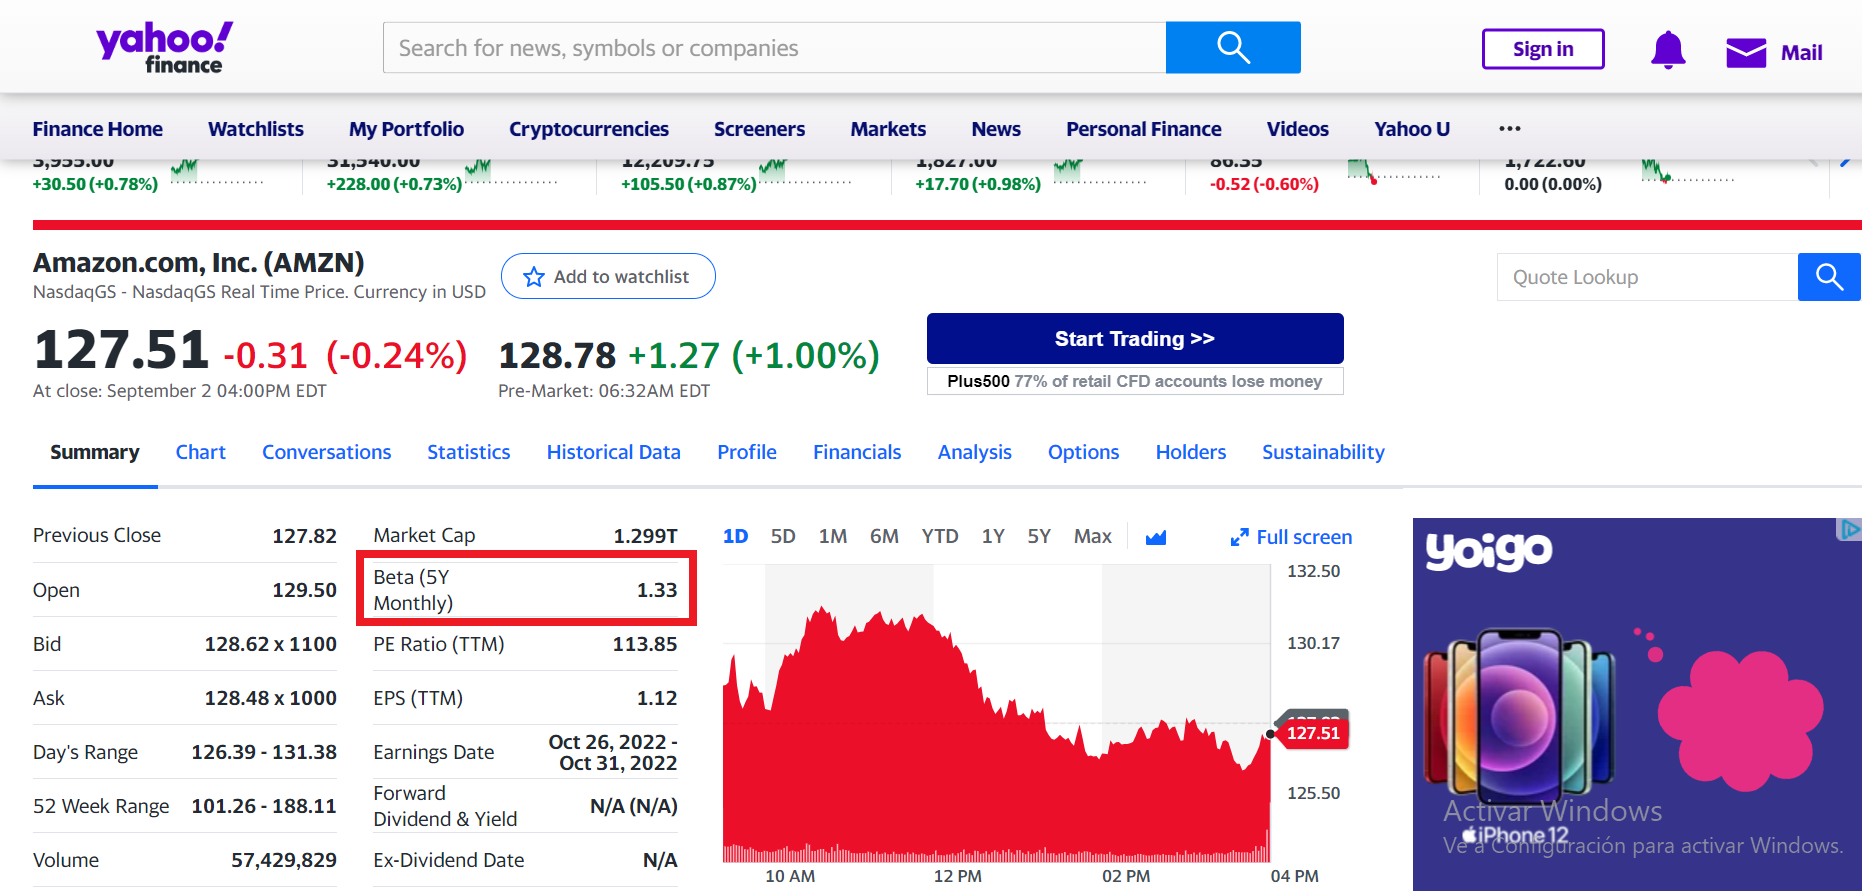